# Update Quotes

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import time
import ray
import talib
import matplotlib.pyplot as plt

2024-07-04 22:54:43,511	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
@ray.remote
def get_symbol_info(id: str, currency: str):
    symbol = id+":"+currency
    url1 = 'https://markets.ft.com/data/funds/tearsheet/performance?s={}'.format(symbol)
    flavor = 'bs4'
    try:
        df1 = pd.read_html(url1, flavor = flavor)[0]

        ds_perform = df1.loc[0].drop(['Unnamed: 0']).apply(lambda x: None if x[:-1] == '-' else float(x[:-1])/100.0)
        ds_perform['ft category'] = df1.loc[1]['Unnamed: 0']

        url2 = 'https://markets.ft.com/data/funds/tearsheet/historical?s={}'.format(symbol)
        df_quotes = pd.read_html(url2, flavor = flavor)[0]
        df_quotes['Date'] = df_quotes['Date'].apply(lambda x: x[:-17]).apply(lambda x: pd.to_datetime(x).date())
        ds_quotes = df_quotes.set_index('Date',drop=True)['Close']

        ds_cat_perform = df1.loc[1].drop(['Unnamed: 0']).apply(lambda x: None if x[:-1] == '-' else float(x[:-1])/100.0)
        ds_cat_perform['ft category'] = df1.loc[1]['Unnamed: 0']
        '''
        url3 = 'https://markets.ft.com/data/funds/tearsheet/risk?s={}'.format(symbol)
        data = pd.read_html(url3)
        ds_risk = pd.concat([data[0], data[1]]).set_index('Unnamed: 0')['Fund']
        ds_cat_risk = pd.concat([data[0], data[1]]).set_index('Unnamed: 0')['Category average']
        '''
    except Exception as e:
        return id, e, None, None
    
    return id, ds_perform, ds_cat_perform, ds_quotes
   

In [3]:
#Load and preprocess XLS exported from BEST
fund_xls = 'MorningstarIWT_ExcelExport.xlsx'
rename_cols = {
    "Legal Name":'name',
    "ExportFile_PriceCurrency":'currency',
    "Category Name":"morningstar_category",
    "ExportFile_Rating":'rating',
    "ExportFile_collectedsrri":"morningstar_risk",
    "ExportFile_Isin":"symbol"}
df = pd.read_excel(fund_xls, sheet_name="Snapshot").rename(columns=rename_cols)
df['rating'] = df['rating'].fillna(0.0).astype(int)
df['morningstar_risk'] = df['morningstar_risk'].fillna(0.0).astype(int)

# df = df[df["rating"]>=4]

In [4]:
data = ray.get([get_symbol_info.remote(fund['symbol'],fund['currency']) for _,fund in df.iterrows()])

2024-07-04 22:54:47,047	INFO worker.py:1752 -- Started a local Ray instance.


KeyboardInterrupt: 

In [ ]:
data

[('DE000A2DR2L2',
  5 years                              0.091
  3 years                             0.0278
  1 year                              0.0275
  6 months                            0.0333
  3 months                           -0.0069
  1 month                            -0.0027
  ft category    Global Small/Mid-Cap Equity
  Name: 0, dtype: object,
  5 years                             0.0524
  3 years                            -0.0157
  1 year                              0.0676
  6 months                            0.0188
  3 months                            -0.028
  1 month                            -0.0095
  ft category    Global Small/Mid-Cap Equity
  Name: 1, dtype: object,
  Date
  2024-07-02    160.18
  2024-07-01    160.06
  2024-06-28    161.28
  2024-06-27    160.95
  2024-06-26    161.32
  2024-06-25    161.72
  2024-06-24    161.68
  2024-06-21    161.32
  2024-06-20    160.16
  2024-06-19    159.58
  2024-06-18    159.56
  2024-06-17    159.71
  2024-06-14    1

In [ ]:
perform_lst, cat_perform_lst, quotes_lst = [],[],[]
for symbol, fp, cp, fq in data:
    if not cp is None:
        perform_lst.append({symbol:fp})
        cat_perform_lst.append({symbol:cp})
        quotes_lst.append(fq.rename(symbol))


In [ ]:
df_perform = pd.concat((pd.DataFrame(df).T for df in perform_lst))
df_cat_perform = pd.concat((pd.DataFrame(df).T for df in cat_perform_lst)).groupby(by="ft category").first()
df_quotes = pd.concat((pd.DataFrame(df) for df in quotes_lst),axis=1)

In [ ]:
df_perform = df_perform.join(df.set_index(keys="symbol", drop=True)[['name','currency','rating',"morningstar_risk"]].rename(columns={"morningstar_risk":"risk"}))
df_perform.to_csv("ft_funds_perform.csv")

df_cat_perform.to_csv("ft_cat_perform.csv")

try:
    df0 = pd.read_csv("ft_quotes.csv",index_col=0,parse_dates=True)
    df0.index = [x.date() for x in df0.index]
    pd.concat([df0.loc[df0.index.difference(df_quotes.index)],df_quotes]).sort_index(ascending=True).to_csv("ft_quotes.csv")
except FileNotFoundError:
    df_quotes.sort_index(ascending=True).to_csv("ft_quotes.csv")

In [ ]:
def tech_kpi(ts: pd.Series) -> pd.DataFrame:
    '''
    Goal: Get Technical Indicators for KAMA
    ts: Time Series with the asset data
    '''
    df = ts.to_frame()

    # Kaufman Adaptive Moving Average (KAMA)
    df['KAMA'] = talib.KAMA(ts, timeperiod=14)

    #Absolute Price Oscillator
    df['APO'] = talib.APO(ts, fastperiod=12, slowperiod=26)

    # Relative Strength Index
    df['RSI'] = talib.RSI(ts, timeperiod=14)

    # Stochastic Relative Strength Index
    df['StochRSI_K'], df['StochRSI_D'] = talib.STOCHRSI(df['RSI'], timeperiod=14, fastk_period=3, fastd_period=3)

    # Calculate ROC
    df['ROC'] = talib.ROC(ts, timeperiod=14)

    # Calculate MACD
    df['MACD'], df['MACD_SIGNAL'], df['MACD_HIST'] = talib.MACD(ts, fastperiod=12, slowperiod=26, signalperiod=9)


    fund_price = df.iloc[:,0]
    
    # Kaufman Adaptive Moving Average (KAMA)
    p_k_diff = fund_price - df['KAMA']
    sign_changes = (p_k_diff * p_k_diff.shift(1) < 0).astype(int)
    df['KAMA Signal'] = sign_changes * p_k_diff.apply(lambda x: 1 if x > 0 else -1)

    ###Absolute Price Oscillator
    '''
    A crossover of the APO above zero might be interpreted as a bullish signal, indicating potential upward momentum. 
    Conversely, a crossover below zero might be considered bearish. 
    Divergences between the APO and the price chart can also be analyzed for potential trend reversals.
    '''
    sign_changes = (df['APO'] * df['APO'].shift(1) < 0).astype(int)
    df['APO Signal'] = sign_changes * df['APO'].apply(lambda x: 1 if x > 0 else -1)

    # Relative Strength Index
    df['RSI Extreme Signal'] = df['RSI'].apply(lambda x: -1 if x >= 70 else (1 if x <= 30 else 0))
    sign_changes = ((df['RSI']-50) * (df['RSI'].shift(1) -50) < 0).astype(int)
    df['RSI Signal'] = sign_changes * df['RSI'].apply(lambda x: 1 if x > 50 else -1) #+ extreme_signals

    # Stochastic Relative Strength Index
    '''
    Overbought (StochRSI > 80): A StochRSI reading above 80 suggests that the market may be overbought, 
    indicating a potential reversal or a slowdown in the upward trend. Traders might consider selling or taking profits.
    Oversold (StochRSI < 20): A StochRSI reading below 20 indicates that the market may be oversold, 
    suggesting a potential reversal or a slowdown in the downward trend. Traders might consider buying or looking for bullish signals.
    A bullish crossover (StochRSI_K crosses above StochRSI_D) may indicate a potential uptrend, 
    while a bearish crossover (StochRSI_K crosses below StochRSI_D) may indicate a potential downtrend.
    '''
    df['StochRSI Extreme Signal'] = df['StochRSI_K'].apply(lambda x: -1 if x >= 80 else (1 if x <= 20 else 0))

    k_d_diff = df['StochRSI_K'] - df['StochRSI_D']
    sign_changes = (k_d_diff * k_d_diff.shift(1) < 0).astype(int)
    df['StochRSI Signal'] = sign_changes * k_d_diff.apply(lambda x: 1 if x > 0 else -1) #+ extreme_signals
    #df['StochRSI Signal'] = df['StochRSI Signal'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    # Calculate MACD
    sign_changes = (df['MACD_HIST'] * df['MACD_HIST'].shift(1) < 0).astype(int)
    df['MACD Signal'] = sign_changes * df['MACD_HIST'].apply(lambda x: 1 if x > 0 else -1)

    # df['TRADING_SIGNAL'] = df.iloc[:,1:].apply(lambda x: x.sum(), axis=1).rolling(window=14).mean()
    df['TRADING_SIGNAL'] = df['APO Signal'] + df['KAMA Signal'] + df['MACD Signal'] #+ df['StochRSI Signal']
    df['Extreme Signal'] = df['StochRSI Extreme Signal'] + df['RSI Extreme Signal']

    return df


def plot_tech_kpi(kpi_df:pd.DataFrame, last_n_days: int=100):
    '''
    Parameters:
    - kpi_df: DataFrame with tehcnical indicators
    - last_n_days: The number of days to be plotted
    Assumptions:
    - First column has the fund price
    '''

    # Create subplots
    _, axes = plt.subplots(nrows=8, ncols=1, figsize=(16,22))

    # Plot the asset price. It assumes the price is in the first column
    kpi_df.iloc[-last_n_days:,0].plot(ax=axes[0])
    kpi_df['KAMA'].iloc[-last_n_days:].plot(ax=axes[0])
    axes[0].set_title(f'{kpi_df.columns[0]} + KAMA')
    axes[0].legend()

    # Plot Trading Signals
    kpi_df['TRADING_SIGNAL'].iloc[-last_n_days:].plot(kind='bar',ax=axes[1])
    axes[1].set_title('Trading Signal')
    axes[1].axhline(0.0, color='grey')

    # Plot Extreme Trading Signals
    kpi_df['Extreme Signal'].iloc[-last_n_days:].plot(kind='bar',ax=axes[2])
    axes[2].set_title('Extreme Trading Signal')
    axes[2].axhline(0.0, color='grey')

    # Plot APO results
    kpi_df['APO'].iloc[-last_n_days:].plot(ax=axes[3])
    axes[3].set_title('Absolute Price Oscillator')
    axes[3].axhline(0.0, color='grey')

    # Plot RSI
    kpi_df['RSI'].iloc[-last_n_days:].plot(ax=axes[4])
    axes[4].set_title('Relative Strength Index')

    # Add overbought and oversold lines
    axes[4].axhline(70, color='r', linestyle='--')
    axes[4].axhline(30, color='r', linestyle='--')
    axes[4].axhline(50, color='grey', linestyle='--')

    # Plot Stochastic RSI
    kpi_df[['StochRSI_K','StochRSI_D']].iloc[-last_n_days:,:].plot(ax=axes[5])
    axes[5].set_title('Stochastic RSI')

    # Add overbought and oversold lines
    axes[5].axhline(80, color='r', linestyle='--')
    axes[5].axhline(20, color='r', linestyle='--')
    axes[5].axhline(50, color='grey', linestyle='--')


    # Plot ROC
    kpi_df['ROC'].iloc[-last_n_days:].plot(ax=axes[6])
    axes[6].set_title('Rate of Change (ROC)')
    axes[6].axhline(0.0, color='grey')

    # Plot MACD
    kpi_df[['MACD','MACD_SIGNAL','MACD_HIST']].iloc[-last_n_days:,:].plot(ax=axes[7])
    axes[7].set_title('Moving Average Convergence/Divergence')
    axes[7].axhline(0.0, color='grey',linestyle='--')

    plt.show()

In [ ]:
df = pd.read_csv("ft_quotes.csv",index_col=0,parse_dates=True)

def get_signal(symbol:str) -> list:
    try:
        ds_kpi = tech_kpi(df[symbol].loc['2023-08-04':].interpolate()).dropna()
    except:
        return [symbol,0.0, 0.0]
    return [symbol,ds_kpi['TRADING_SIGNAL'][-5:].sum(), ds_kpi['Extreme Signal'][-5:].mean()/2.0]

In [ ]:

df_trading_signal = pd.DataFrame([get_signal(symbol) for symbol in df.columns[:]], columns=['symbol','Trading Signal','Extreme Signal'])
df_trading_signal.dropna(inplace=True)
df_trading_signal.to_csv('ft_trading_signals.csv',index=False)

In [ ]:
df_trading_signal.set_index('symbol',inplace=True)
ds = (df_trading_signal['Trading Signal']+df_trading_signal['Extreme Signal']).sort_values(ascending=False)
ds[ds > 1]

symbol
LU0566484027    3.1
LU1476608713    3.0
LU1670618344    3.0
LU0119111028    3.0
LU0210635339    3.0
               ... 
LU0319791611    1.1
LU0544572786    1.1
LU0178439666    1.1
LU0365761625    1.1
LU0608810734    1.1
Length: 147, dtype: float64

In [ ]:
df_trading_signal.loc['LU1071463183']

Trading Signal   -1.0
Extreme Signal    0.0
Name: LU1071463183, dtype: float64

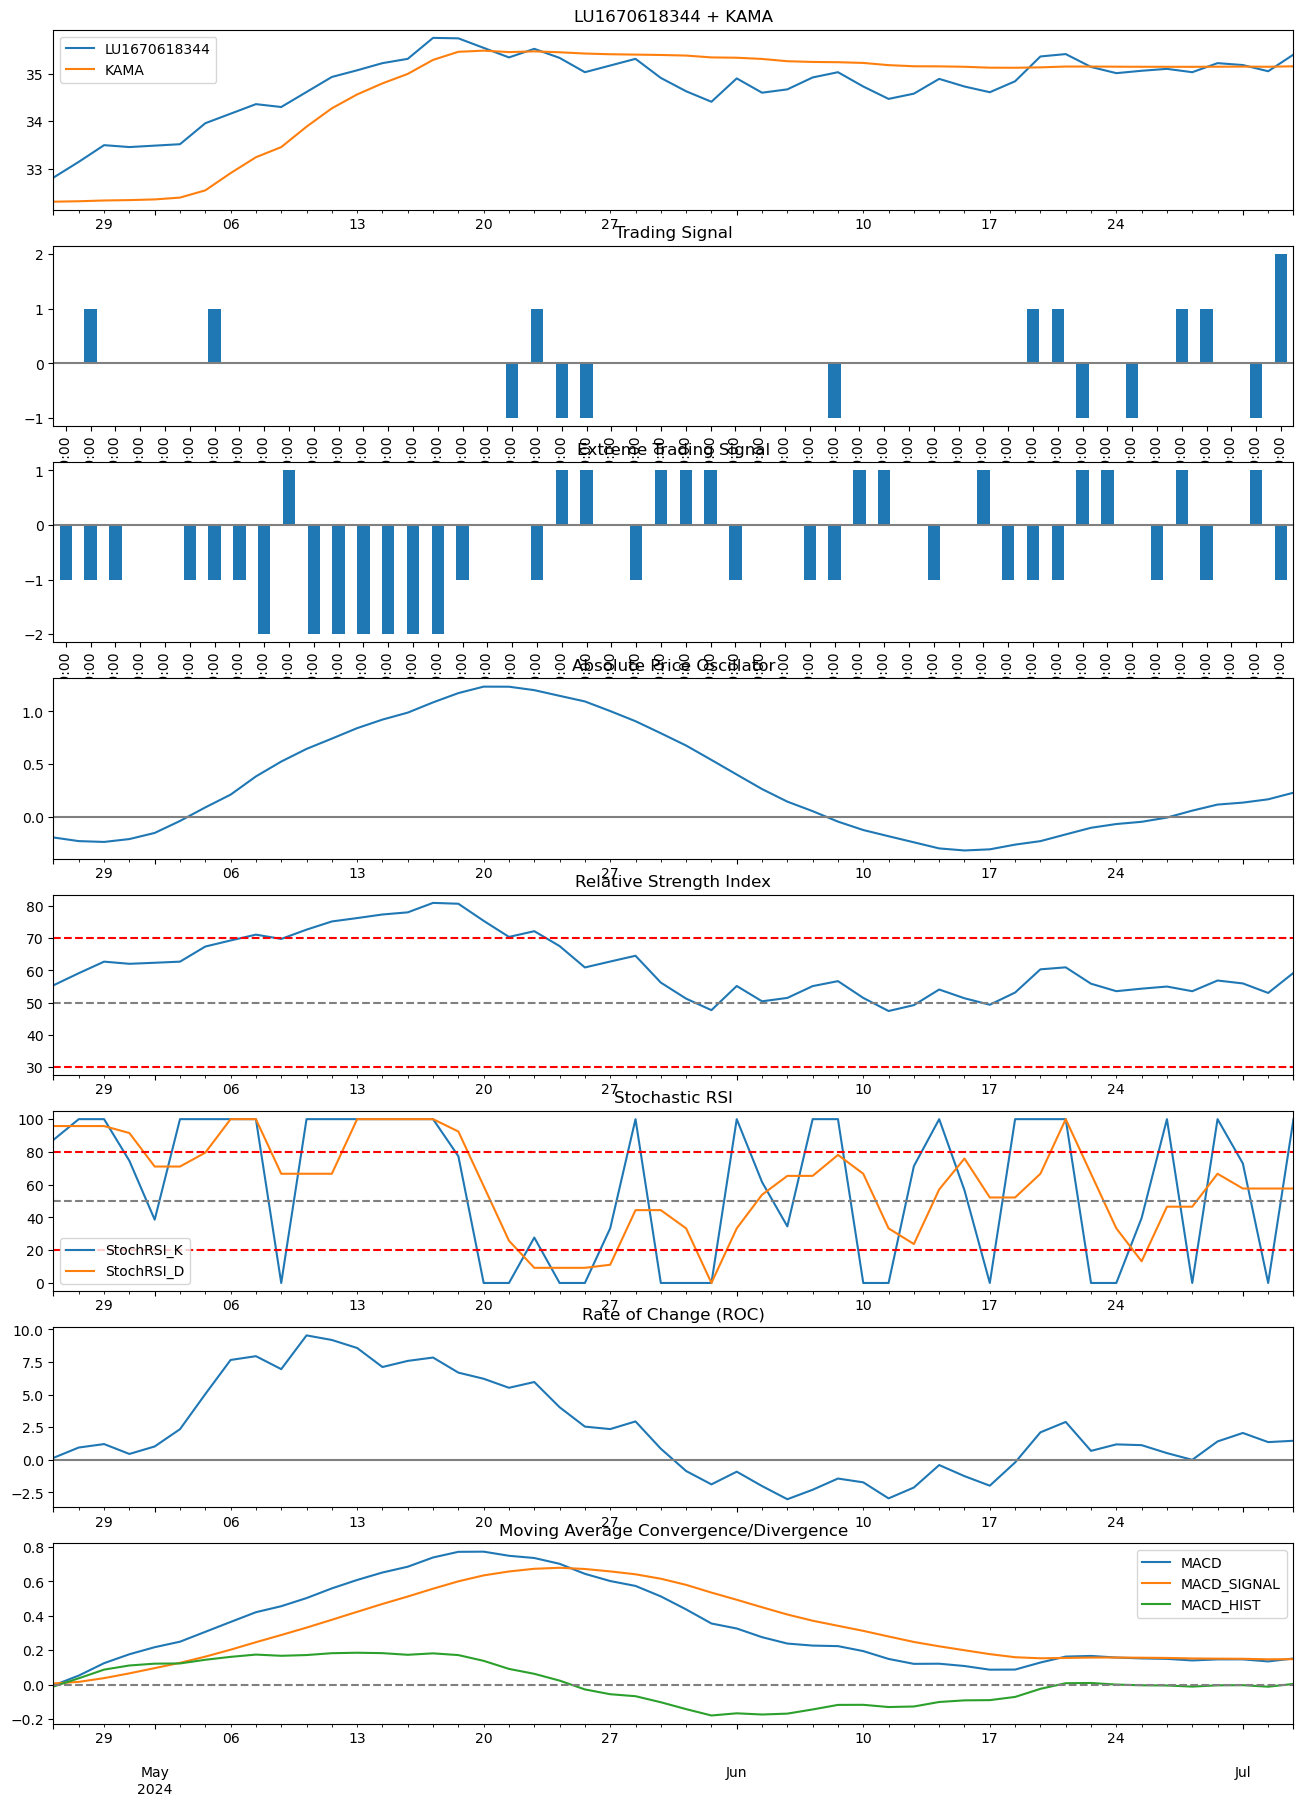

In [ ]:
ds_kpi=tech_kpi(df[ds[ds > 1].index[2]].loc['2023-08-04':].interpolate())
plot_tech_kpi(ds_kpi,50)